<Learnings>

Different types of molecule representation:
- .xyz format: shows the atomic cartesian coordinates of each atom in a molecule
    - (x,y,z) coordinate of each atom in a molecule
- .smi (SMILES) format: shows the the structure of a molecule in a 2D format
    - rules:
        1) Atoms are represented by its atomic symbol
            - If consist of two letters, the following is in lower case
            - Lower case is also used for aromatic rings
        2) Single bonds are not represented
            - Double bonds are represented with =
            - Triple bonds are represented with #
            -
        3) Hydrogens are implicit
            - If notify one Hydrogen, it is the only hydrogen in the structure
        4) Branches are represented in parenthesis
        5) Rings are represented with numbers, of where the ring starts and close
- fingerprint
- columb matrix
...

Discriptors: numeric value that describes property of a molecule
    e.g. MW of 46.07, LogP of 0.5
- Imposes instrinsic meanings to the numbers

<Libraries needed for the project>
- RDkit: Library used to extract molecular information from a SMILES representation
- mordred: Molecular descriptor calculator
- molml: Interface molecules to machine learning. Convert molecules into vector representation


In [3]:
# import libraries for data wrangling:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from rdkit import Chem
from rdkit.Chem import Draw
from mordred import descriptors, Calculator
from molml.features import CoulombMatrix


17

gdb 35176	3.69951	1.23093	1.09709	5.0509	78.3	-0.2676	0.0141	0.2818	1120.8417	0.137571	-380.797809	-380.79051	-380.789566	-380.829714	28.666	

N	-0.1158211823	-1.1588814083	 0.0253875797	-0.33752

C	-0.0634755918	-0.0038135736	 0.037200671	 0.335786

C	 0.0110718662	 1.4360892201	 0.0060552095	-0.351511

N	 0.5872156127	 2.0980870138	 1.2241547256	-0.40181

C	 1.3066483466	 2.1572458324	-0.0191184789	 0.488704

C	 2.7569832432	 1.7502741759	-0.3116380498	-0.12094

C	 2.4855003157	 2.2287618766	-1.7724735543	-0.215041

C	 1.8365633238	 3.3230156624	-0.8677898469	-0.150471

C	 3.1222090314	 3.2335825367	 0.0190305135	-0.223719

H	-0.8402848187	 1.9119567184	-0.4739629271	 0.133233

H	 0.0720428663	 2.9567193044	 1.4093287021	 0.24383

H	 3.2686458366	 0.8463850226	 0.0131731084	 0.100189

H	 3.3646646552	 2.5453426122	-2.3375094804	 0.102145

H	 1.8106735614	 1.6191840124	-2.3774773862	 0.106847

H	 1.2994311493	 4.2188724372	-1.1813921281	 0.081344

H	 3.0295061775	 3.5421096693	 1.

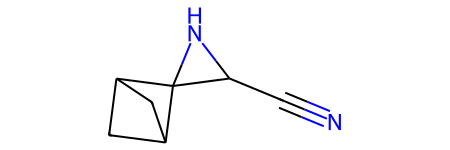

In [4]:
# Check number of XYZ files in directory
directory = "Data/dsgdb9nsd.xyz"
len(os.listdir(directory)) 

# Sample XYZ file for testing
sample_file = os.listdir(directory)[0] # gives out an abitrary file list, so ultimately is random
with open(os.path.join(directory, sample_file), 'r') as f:
    content = f.readlines() # readlines() gives a list of the lines in XYZ file
for line in content:
    print(line) 

# SMILES representation of the molecule is in the line n + 4
smile_example = Chem.MolFromSmiles(content[17 + 3].split()[0]) # Since line starts from 0, we need to add 3 to the line number
smile_example

In [5]:
# Reading the entire dataset
def read_xyz(path):
    """
    Reads the xyz files in the directory on 'path'
    Input
    path: the path to the folder to be read
    
    Output
    atoms: list with the characters representing the atoms of a molecule
    coordinates: list with the cartesian coordinates of each atom
    smile: list with the SMILE representation of a molecule
    prop: list with the scalar properties
    """
    atoms = []
    coordinates = []
    with open(path, 'r') as f:
        lines = f.readlines()
        num_atoms = int(lines[0])
        smile = lines[num_atoms + 3].split()[0]
        prop = lines[1].split()[2:] # The first two elements are the data set name and the number of index
        for i in lines[2:num_atoms + 2]:
            i = i.split()
            atom = i[0]
            atoms.append(atom) # Atoms are stored as a list of strings
            try:
                x = float(i[1])
                y = float(i[2])
                z = float(i[3])
                coordinates.append((x, y, z)) # Coordinates are stored as a tuple of lists
            except: # Some coordinates are include exponent notation
                x = float(i[1].replace('*^', 'e'))
                y = float(i[2].replace('*^', 'e'))
                z = float(i[3].replace('*^', 'e'))
                coordinates.append((x, y, z))
    return atoms, coordinates, smile, prop

In [6]:
# Read the entire dataset and return atoms, coordinates, smiles and properties
data = []
smiles = []
properties = []

for file in os.listdir(directory):
    atoms, coordinates, smile, prop = read_xyz(os.path.join(directory, file))
    data.append([atoms, coordinates])
    smiles.append(smile)
    properties.append(prop)

print ("Number of molecules in the dataset: ", len(data))
print ("Number of properties in the dataset: ", len(properties))
print ("Number of smiles in the dataset: ", len(smiles))

Number of molecules in the dataset:  133885
Number of properties in the dataset:  133885
Number of smiles in the dataset:  133885


In [7]:
# Saving data list for use in other modules
import csv
with open('cm_eigen.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(data)

In [8]:
# Properties and Data will be stored in a single dataframe
property_names = ['A', 'B', 'C', 'mu', 'alfa', 'homo', 'lumo', 'gap', 'R²', 'zpve', 'U0', 'U', 'H', 'G', 'Cv']
property_df = pd.DataFrame(properties, columns = property_names).astype("float32")
smiles_df = pd.DataFrame(smiles, columns = ["smiles"])
df = pd.concat([property_df,smiles_df],axis =1) # Using pd.concat() combines everything at once and avoids unnecessary memory copying

# Read each molecule by its SMILES string
valid_mols = []
for smi in smiles:
    mol = Chem.MolFromSmiles(smi)
    valid_mols.append(mol)
mol_df = pd.DataFrame(valid_mols, columns = ['mol'])

# Concat to main df and check if there are any Null values
df = pd.concat([df, mol_df], axis=1)
df['mol'].isnull().sum()


0

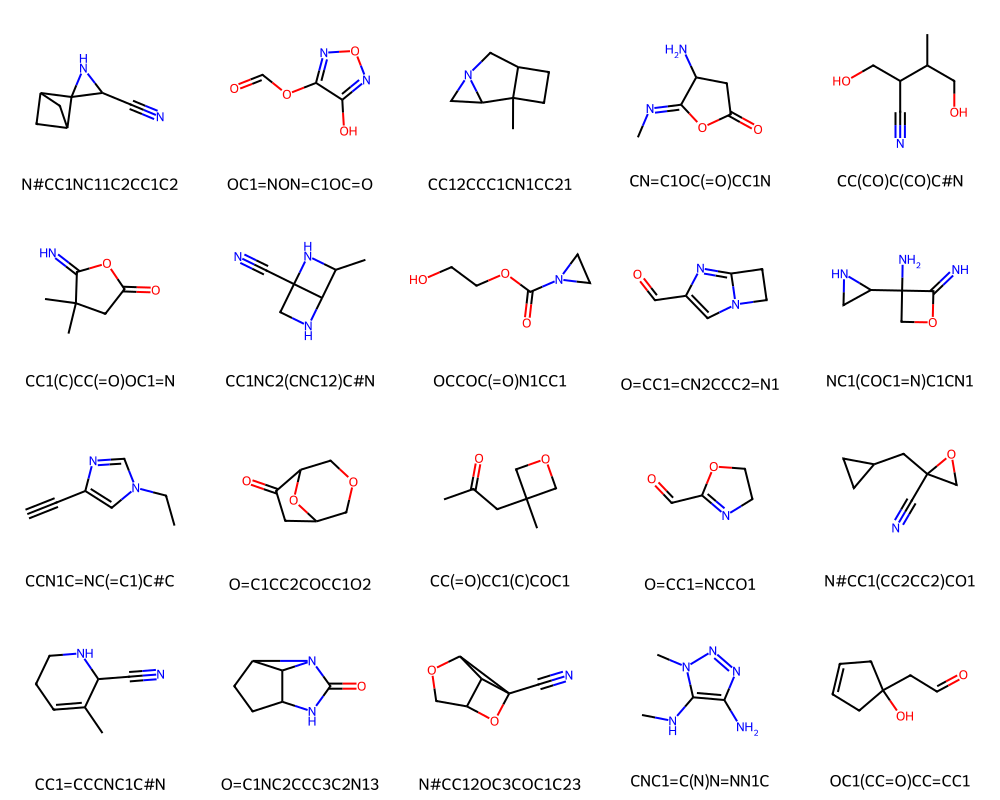

In [9]:
# Reads and prints the 20 first molecules
mol = df['mol'][:20]
Draw.MolsToGridImage(mol, molsPerRow=5, useSVG=True, legends=list(df['smiles'][:20].values))
# Draws multiple RDKit mol object and display in grid like formation
# useSVG enables vector graphics instead of pixel graphics, resulting in a better quality image

17
9


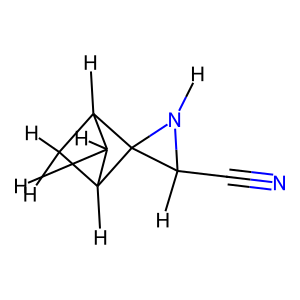

In [10]:
# SMILES representation does not contain hydrogen atoms
# Need to add hydrogen count to the RDKit mol object
df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))

# Make a seperate column for number of atoms and number of heavy atoms
df['num_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
df['num_heavy_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())

print(df['num_atoms'][0]) 
print(df['num_heavy_atoms'][0]) 
Draw.MolToImage(df['mol'][0]) # Draws a single RDKit mol object


In [11]:
# Creating canonical SMILE representation is essential for normalization of the representation
# Smiles representation to mol object and back to smiles representation
def canonicalize_smiles(smiles):
    return Chem.MolToSmiles(Chem.MolFromSmiles(mol), isomericSmiles=True, canonical=True)
# isomericSmiles is used to keep the stereochemistry of the molecule; Chirality and double bonds
# canonical is used to keep the canonical SMILES representation

canonical_smile = []
for mol in smiles:
    canonical_smile.append(canonicalize_smiles(mol))

df['canonical_smile'] = canonical_smile

In [12]:
# Check for duplicates
df['canonical_smile'][df['canonical_smile'].duplicated()]


17903             NC=Nc1cnccn1
24934             Cc1cnc(F)cn1
27909            CN(C)c1cnccn1
28007     O=[N+]([O-])c1cnccn1
30292          c1cnc(N2CC2)cn1
                  ...         
131653           CC(C)c1cnccn1
132483           CNc1cnc(F)cn1
133438          C#Cc1cnc(O)cn1
133655          N#Cc1cnc(O)cn1
133850          C#Cc1cnc(N)cn1
Name: canonical_smile, Length: 87, dtype: object

In [13]:
# Investigate the duplicates
df[df['canonical_smile'] == "Cc1cnc(F)cn1" ]

,A,B,C,mu,alfa,homo,lumo,gap,R²,zpve,U0,U,H,G,Cv,smiles,mol,num_atoms,num_heavy_atoms,canonical_smile
8282,5.89515,1.52518,1.22084,1.7943,62.959999,-0.2623,-0.0557,0.2066,911.562073,0.096076,-402.805389,-402.798767,-402.797821,-402.836609,24.076,CC1=CN=C(F)C=N1,<rdkit.Chem.rdchem.Mol object at 0x36a717f40>,13,8,Cc1cnc(F)cn1
24934,5.89515,1.52518,1.22084,1.7943,62.959999,-0.2623,-0.0557,0.2066,911.563477,0.096076,-402.805389,-402.798767,-402.797821,-402.836609,24.076,CC1=NC=C(F)N=C1,<rdkit.Chem.rdchem.Mol object at 0x36f4e3530>,13,8,Cc1cnc(F)cn1


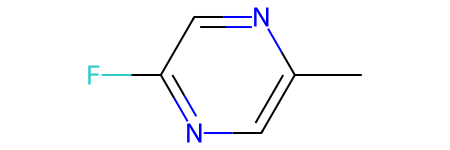

In [14]:
# index 8282 
Chem.MolFromSmiles("CC1=CN=C(F)C=N1")

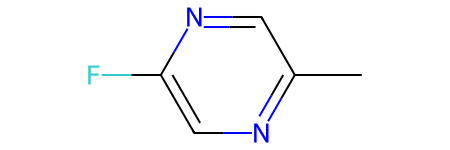

In [15]:
# index = 24934
Chem.MolFromSmiles("CC1=NC=C(F)N=C1")

In [16]:
# Molecules are same, so will drop duplicates
df = df.drop_duplicates(subset='canonical_smile', keep='first')

# Reset the index
df = df.reset_index(drop=True)

# Check for duplicates again
df['canonical_smile'][df['canonical_smile'].duplicated()]

Series([], Name: canonical_smile, dtype: object)

In [17]:
# RDKit objects will be regenerated utilizing the canonical SMILES representation
df['mol'] = df['canonical_smile'].apply(lambda x: Chem.MolFromSmiles(x))

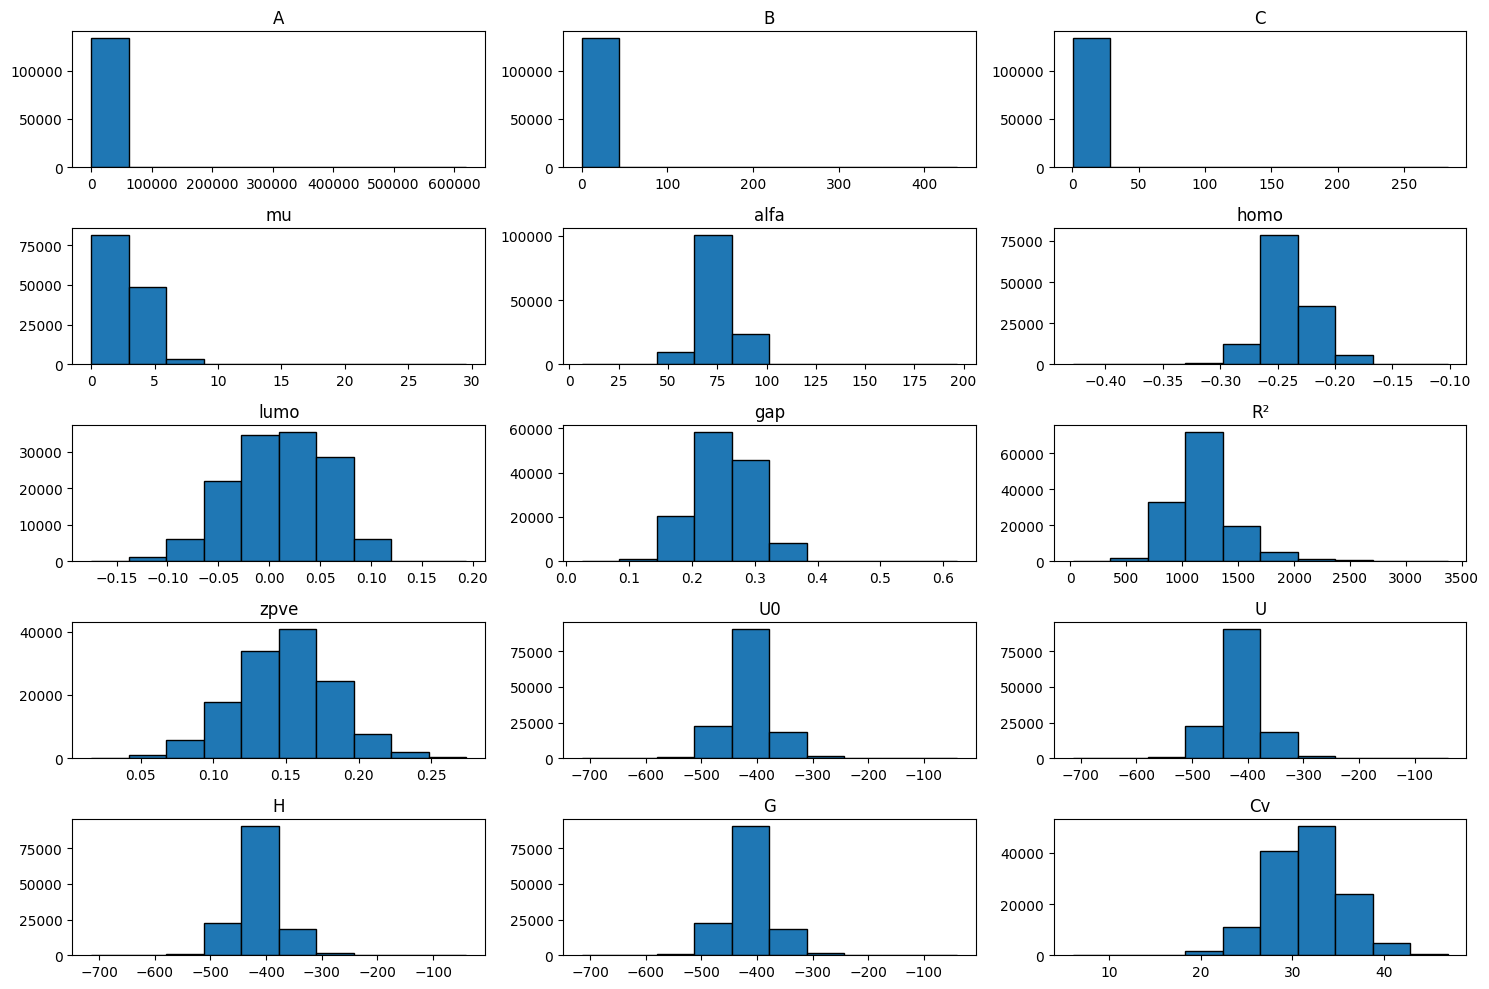

In [18]:
# Property values will be investigated
# Check for outliers first
plt.figure(figsize=(15, 10))
plot_counter = 1
for prop in df.iloc[:,:15].columns:
    plt.subplot(5, 3, plot_counter)
    plt.hist(df.iloc[:,:15][prop], edgecolor='k')
    plt.title(prop)
    plot_counter += 1
plt.tight_layout()
plt.show()

In [19]:
# Check statistics of the properties
df.describe()

,A,B,C,mu,alfa,homo,lumo,gap,R²,zpve,U0,U,H,G,Cv,num_atoms,num_heavy_atoms
count,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000,133798.000000
mean,9.817750,1.406112,1.124983,2.706031,75.192825,-0.239977,0.011164,0.251141,1189.569214,0.148550,-411.537964,-411.529449,-411.528473,-411.571320,31.603436,17.986069,8.795886
std,1810.053833,1.584265,1.095953,1.530345,8.187228,0.022133,0.046923,0.047507,279.796112,0.033264,40.056843,40.056622,40.056622,40.057354,4.061663,2.953332,0.508952
min,0.000000,0.337120,0.331180,0.000000,6.310000,-0.428600,-0.175000,0.024600,19.000200,0.015951,-714.568054,-714.560181,-714.559204,-714.602112,6.002000,3.000000,1.000000
25%,2.554310,1.091790,0.910563,1.588800,70.379997,-0.252500,-0.023800,0.216300,1018.340546,0.125308,-437.913811,-437.905693,-437.904755,-437.947525,28.945000,16.000000,9.000000
50%,3.089935,1.370030,1.078720,2.500050,75.500000,-0.241000,0.012000,0.249500,1147.573181,0.148341,-417.864075,-417.856445,-417.855499,-417.895630,31.556999,18.000000,9.000000
75%,3.834450,1.653957,1.279640,3.635900,80.519997,-0.228700,0.049200,0.288200,1308.888245,0.171158,-387.049057,-387.039703,-387.038757,-387.083221,34.278000,20.000000,9.000000
max,619867.687500,437.903870,282.945465,29.556400,196.619995,-0.101700,0.193500,0.622100,3374.753174,0.273944,-40.478931,-40.476063,-40.475117,-40.498596,46.969002,29.000000,9.000000


In [20]:
# For A, B and C; Max values are much larger than the mean indicating the presence of outliers
# Check for outliers in A, B and C
df[df['A']>100]

,A,B,C,mu,alfa,homo,lumo,gap,R²,zpve,U0,U,H,G,Cv,smiles,mol,num_atoms,num_heavy_atoms,canonical_smile
18410,159.871170,0.379330,0.379330,1.9087,143.529999,-0.2266,-0.0676,0.1589,2708.153809,0.085798,-345.074463,-345.064758,-345.063812,-345.108856,33.347000,CC#CC#CC#CC#C,<rdkit.Chem.rdchem.Mol object at 0x3b1e1d460>,13,9,C#CC#CC#CC#CC
20529,159.619873,0.782570,0.782570,6.3203,82.739998,-0.2665,-0.0718,0.1947,1344.432739,0.065892,-285.016357,-285.009094,-285.008148,-285.047272,23.785999,CC#CC#CC#N,<rdkit.Chem.rdchem.Mol object at 0x3b1e57b50>,10,7,CC#CC#CC#N
21520,159.934586,0.783440,0.783440,1.5732,92.339996,-0.2323,-0.0452,0.1871,1373.624756,0.075867,-268.917908,-268.910156,-268.909241,-268.949005,26.267000,CC#CC#CC#C,<rdkit.Chem.rdchem.Mol object at 0x3b1e730d0>,11,7,C#CC#CC#CC
23641,159.655106,0.377100,0.377100,7.3662,130.860001,-0.2540,-0.0911,0.1628,2674.166504,0.076809,-361.170929,-361.161896,-361.160950,-361.205109,29.965000,CC#CC#CC#CC#N,<rdkit.Chem.rdchem.Mol object at 0x3b1ead930>,12,9,CC#CC#CC#CC#N
26441,619867.687500,1.334550,1.334540,0.0151,72.389999,-0.2465,-0.0565,0.1900,802.148499,0.046718,-229.615448,-229.609222,-229.608276,-229.639954,21.875000,C#CC#CC#C,<rdkit.Chem.rdchem.Mol object at 0x3b1eface0>,8,6,C#CC#CC#C
62592,127.834969,24.858721,23.978720,1.5258,16.969999,-0.2653,0.0784,0.3437,83.793999,0.051208,-115.679138,-115.675819,-115.674873,-115.701874,8.751000,CO,<rdkit.Chem.rdchem.Mol object at 0x3c1a93610>,6,2,CO
62794,160.280411,8.593230,8.593210,0.7156,28.780001,-0.2609,0.0613,0.3222,177.196304,0.055410,-116.609550,-116.605553,-116.604607,-116.633774,12.482000,CC#C,<rdkit.Chem.rdchem.Mol object at 0x3c1a98f90>,7,3,C#CC
71031,159.035675,9.223270,9.223240,3.8266,24.450001,-0.3264,0.0376,0.3640,160.722305,0.045286,-132.718155,-132.714569,-132.713623,-132.742142,10.287000,CC#N,<rdkit.Chem.rdchem.Mol object at 0x3c557c350>,6,3,CC#N
79545,285.488403,38.982300,34.298920,2.1089,14.180000,-0.2670,-0.0406,0.2263,59.989101,0.026603,-114.483612,-114.480743,-114.479805,-114.505264,6.413000,C=O,<rdkit.Chem.rdchem.Mol object at 0x3c8f670d0>,4,2,C=O
87430,293.609741,293.541107,191.393967,1.6256,9.460000,-0.2570,0.0829,0.3399,26.156300,0.034358,-56.525887,-56.523026,-56.522083,-56.544960,6.316000,N,<rdkit.Chem.rdchem.Mol object at 0x3cca40970>,4,1,N


In [21]:
# Will be dropping the index 26441 and 103389 due to extensive outliers
df = df.drop([26441, 103389])

# Reset the index
df = df.reset_index(drop=True)

# Outliers in B and C wasn't as extensive as A so will not be dropping them
df[df['B']>100]
df[df['C']>100]

,A,B,C,mu,alfa,homo,lumo,gap,R²,zpve,U0,U,H,G,Cv,smiles,mol,num_atoms,num_heavy_atoms,canonical_smile
87429,293.609741,293.541107,191.393967,1.6256,9.46,-0.2570,0.0829,0.3399,26.156300,0.034358,-56.525887,-56.523026,-56.522083,-56.544960,6.316,N,<rdkit.Chem.rdchem.Mol object at 0x3cca40970>,4,1,N
88127,799.588135,437.903870,282.945465,1.8511,6.31,-0.2928,0.0687,0.3615,19.000200,0.021375,-76.404701,-76.401871,-76.400925,-76.422348,6.002,O,<rdkit.Chem.rdchem.Mol object at 0x3cca53d10>,3,1,O
95569,157.711807,157.709976,157.706985,0.0000,13.21,-0.3877,0.1171,0.5048,35.364101,0.044749,-40.478931,-40.476063,-40.475117,-40.498596,6.469,C,<rdkit.Chem.rdchem.Mol object at 0x3d0621230>,5,1,C


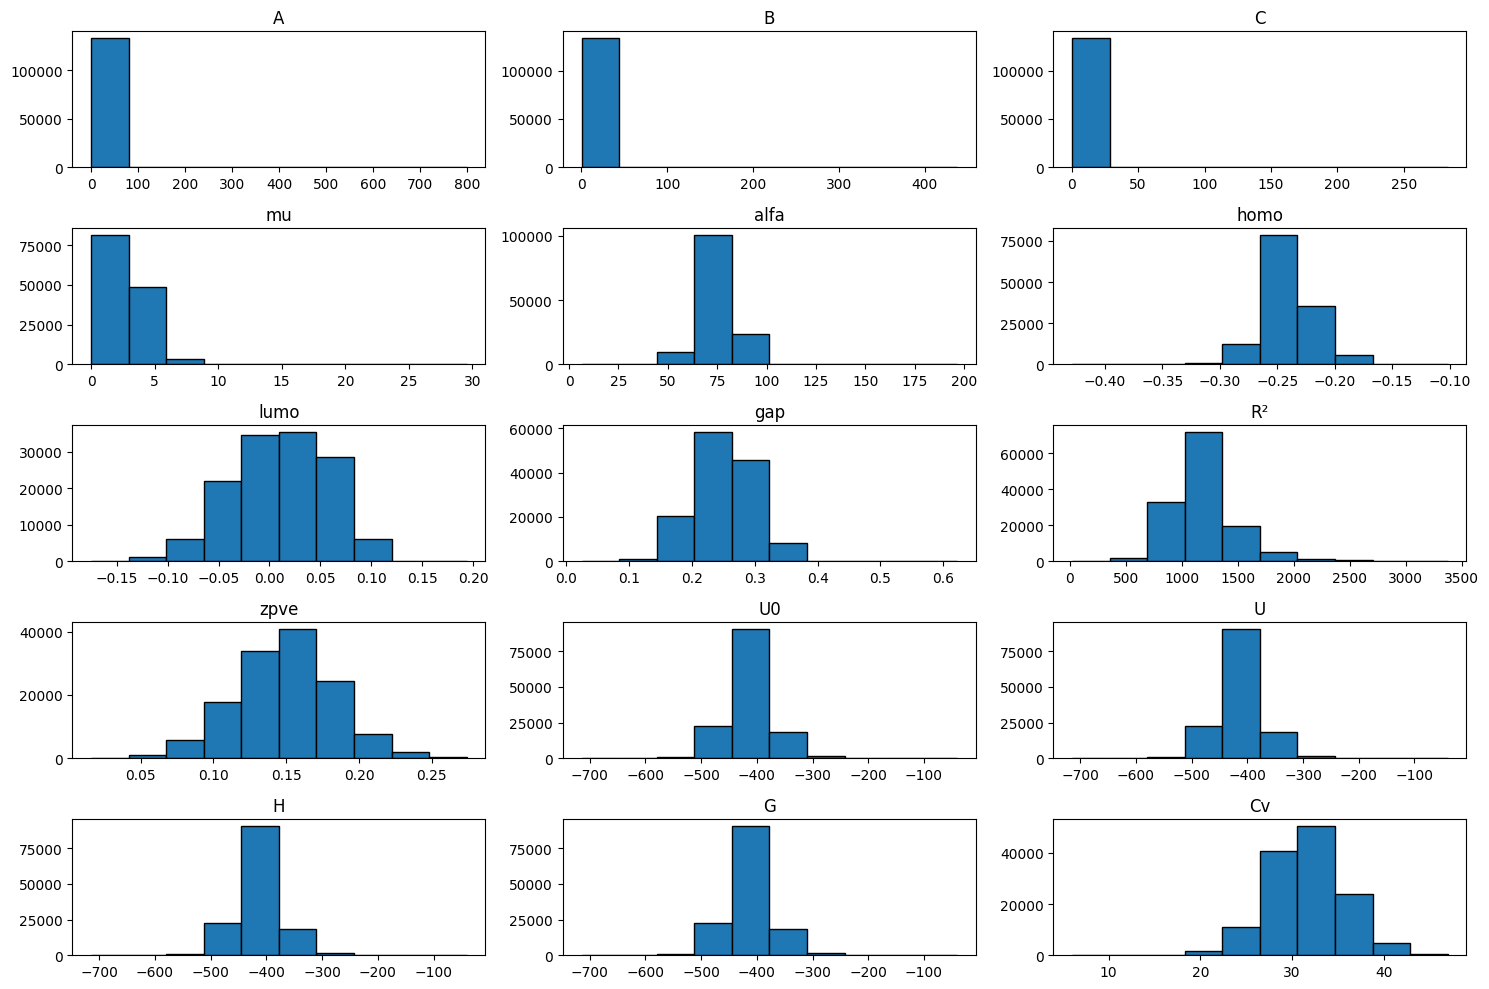

In [22]:
# Check plots again
plt.figure(figsize=(15, 10))
plot_counter = 1
for prop in df.iloc[:,:15].columns:
    plt.subplot(5, 3, plot_counter)
    plt.hist(df.iloc[:,:15][prop], edgecolor='k')
    plt.title(prop)
    plot_counter += 1
plt.tight_layout()
plt.show()

# A outliers were reduced 

In [23]:
# Save dataframe to csv
df.to_csv('processed_data.csv', index=False)